In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset Range

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import os
import numpy as np
from tqdm import tqdm

# Get current project directory
current_dir = os.getcwd()
ROOT_DIR = os.path.dirname(current_dir)


class COCODataset(Dataset):
    def __init__(self, img_dir, annotation_file, target_classes, transform=None, mode ="train"):
        self.img_dir = img_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())  
        self.transform = transform
        self.target_classes = target_classes
        self.mode = mode  # "train" or "test"

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_info = self.coco.loadImgs(image_id)[0]

        # Load annotations
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)

        category_counts = np.zeros(len(self.target_classes), dtype=np.float32)

        for ann in annotations:
            if ann['category_id'] in self.target_classes: 
                category_counts[self.target_classes.index(ann['category_id'])] += 1

        category_counts = torch.tensor(category_counts, dtype=torch.float32) 

        return torch.tensor(image_id), category_counts

def get_COCO_dataset(target_classes, is_train_blurred=False): 
    
    # load train data
    print("Loading Training Data...")
    train_dataset = COCODataset(
        f'{ROOT_DIR}/data/COCO/images/train2017',
        f'{ROOT_DIR}/data/COCO/annotations/instances_train2017.json',
        target_classes,
    )
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    # sanity check
    print("train_dataset size:", len(train_dataset))
    print("train_loader size:", len(train_dataloader))

    return train_dataset,train_dataloader
 

# Function to convert dataset to DataFrame
def dataset_to_dataframe(dataloader, target_classes):
    image_ids = []
    category_counts_list = []

    for img_id, category_counts in dataloader:
        image_ids.extend(img_id.tolist())  # Convert tensor to list
        category_counts_list.extend(category_counts.tolist())  # Convert tensor to list

    # Create DataFrame
    df = pd.DataFrame(category_counts_list, columns=[f"Class_{cls}" for cls in target_classes])
    df.insert(0, "Image_ID", image_ids)  # Add image ID as the first column

    return df


train_dataset,train_dataloader = get_COCO_dataset([1])
df = dataset_to_dataframe(train_dataloader, [1])




c:\Users\pcqm0\anaconda3\envs\fypEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Training Data...
loading annotations into memory...
Done (t=23.25s)
creating index...
index created!
train_dataset size: 118287
train_loader size: 7393
   Image_ID  Class_1
0        64      0.0
1    288761      1.0
2    123147      9.0
3    326064      0.0
4    294528      1.0


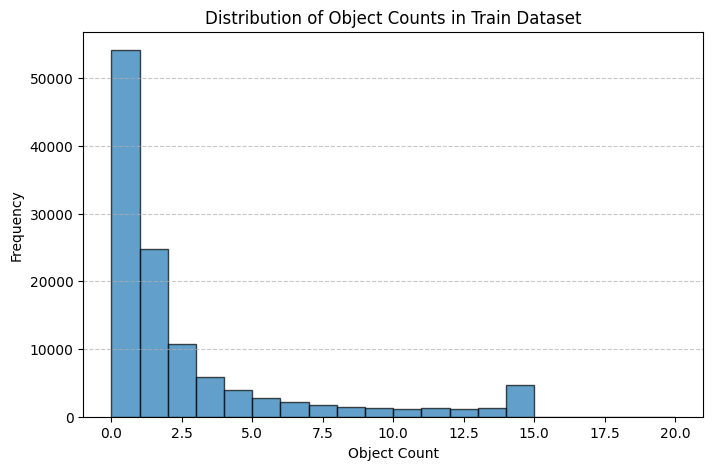

In [174]:
df.head()

 # Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df["Class_1"], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Object Count")
plt.ylabel("Frequency")
plt.title("Distribution of Object Counts in Train Dataset")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pretrained Model

### Evaluation Scores

In [2]:
def calculateScores(filename):
    extract_element = lambda x: extract_element(x[0]) if isinstance(x, list) and len(x) == 1 else x

    results = pd.read_json(filename)
    results["ground_truths"] = results["ground_truths"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(lambda x: max(0, round(x)))

    results["square_error"] = results.apply(lambda row: np.square(np.array(row["prediction"]) - np.array(row["ground_truths"])).tolist(), axis=1)
    results["absolute_error"] = results.apply(lambda row: abs(np.array(row["prediction"]) - np.array(row["ground_truths"])).tolist(), axis=1)
    results["exact_match"] = results.apply(lambda row: np.where(np.array(row["square_error"]) == 0,1,0), axis=1)

    MSE = np.mean(np.array(results["square_error"].tolist()), axis=0)
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.array(results["absolute_error"].tolist()), axis=0)
    EMR = np.mean(np.array(results["exact_match"].tolist()), axis=0) * 100

    return MSE,RMSE, MAE, EMR 


In [3]:
def calculateScores2(filename):
    extract_element = lambda x: extract_element(x[0]) if isinstance(x, list) and len(x) == 1 else x

    results = pd.read_json(filename)
    results["ground_truths"] = results["ground_truths"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(lambda x: max(0, round(x)))

    results = results[results["ground_truths"] != 0]

    results["square_error"] = results.apply(lambda row: np.square((row["prediction"]) - (row["ground_truths"])), axis=1)
    results["absolute_error"] = results.apply(lambda row: abs((row["prediction"]) - (row["ground_truths"])), axis=1)
    results["absolute_percentage_error"] = results.apply(lambda row: (abs(row["ground_truths"] - row["prediction"]) / max(row["ground_truths"], 1e-6)),axis=1)
    results["exact_match"] = results.apply(lambda row: np.where(np.array(row["square_error"]) == 0,1,0), axis=1)

    MSE = np.mean(np.array(results["square_error"].tolist()), axis=0)
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.array(results["absolute_error"].tolist()), axis=0)
    MAPE = np.mean(np.array(results["absolute_percentage_error"].tolist()), axis=0)
    EMR = np.mean(np.array(results["exact_match"].tolist()), axis=0) * 100

    return MSE,RMSE, MAE,  MAPE, EMR 


In [4]:
def displayScore(modelname):
    MSE2, RMSE2, MAE2, MAPE2, EMR2 = calculateScores2(f'{modelname}_results.json')
    MSE_blurred2, RMSE_blurred2, MAE_blurred2, MAPE_blurred2, EMR_blurred2 = calculateScores2(f'{modelname}_results_on_blurred_images.json')
    MSE, RMSE, MAE, EMR = calculateScores(f'{modelname}_results.json')
    MSE_blurred, RMSE_blurred, MAE_blurred, EMR_blurred = calculateScores(f'{modelname}_results_on_blurred_images.json')
    

    return {
        "model":modelname,
        "mean_square_error":MSE,
        "root_mean_square_error":RMSE, 
        "mean_absolute_error":MAE,
        "exact_match_percentage":EMR,
        "mean_square_error_blurred_images":MSE_blurred,
        "root_mean_square_error_blurred_images":RMSE_blurred, 
        "mean_absolute_error_blurred_images":MAE_blurred,
        "exact_match_percentage_blurred_images":EMR_blurred,
        "mean_square_error2":MSE2,
        "root_mean_square_error2":RMSE2, 
        "mean_absolute_error2":MAE2,
        "mean_absolute_percentage_error2":MAPE2,
        "exact_match_percentage2":EMR2,
        "mean_square_error_blurred_images2":MSE_blurred2,
        "root_mean_square_error_blurred_images2":RMSE_blurred2, 
        "mean_absolute_error_blurred_images2":MAE_blurred2,
        "mean_absolute_percentage_error_blurred_images2":MAPE_blurred2,
        "exact_match_percentage_blurred_images2":EMR_blurred2,
    }

In [5]:


results = [] 

# # Calculate pretrained models results
# pretrained_file = ["pretrained_fasterrcnn", "pretrained_maskrcnn", "pretrained_retinanet", "pretrained_ssd"] 
# for name in pretrained_file: 
#     results.append(displayScore(name))

# results.append(displayScore("ViT_checkpoint_5"))

# for i in range(8,11): 
#     results.append(displayScore(f"ViT_{i}"))

# for i in range(9,11): 
#     results.append(displayScore(f"ViT_image_blur_{i}"))

# for i in range(1,17): 
#     results.append(displayScore(f"ViT_density_{i}"))

# # for i in range(1,7): 
# #     results.append(displayScore(f"self_attention_v2_{i}"))

# # for i in range(1,11): 
# #     results.append(displayScore(f"cross_attention_v2_{i}"))

# # for i in range(1,6): 
# #     results.append(displayScore(f"ViT_density_v2_{i}"))

# for i in [2,7,8,9]: 
#     results.append(displayScore(f"self_attention_{i}"))




# for i in [1,2,3,16]: 
#     results.append(displayScore(f"self_attention_image_blur_{i}"))

# for i in [3,7]: 
#     results.append(displayScore(f"cross_attention_{i}"))


for i in range(1,9): 
    results.append(displayScore(f"cross_attention_image_blur_{i}"))





In [135]:

results2 = [] 

# Calculate pretrained models results
pretrained_file = ["pretrained_fasterrcnn", "pretrained_maskrcnn", "pretrained_retinanet", "pretrained_ssd"] 
for name in pretrained_file: 
    results2.append(displayScore(name))

for i in range(1,7): 
    results2.append(displayScore(f"self_attention_v2_{i}"))

for i in range(1,11): 
    results2.append(displayScore(f"cross_attention_v2_{i}"))

for i in range(1,6): 
    results2.append(displayScore(f"ViT_density_v2_{i}"))



In [137]:
results_df = pd.DataFrame(results2)
results_df.to_csv("results2.csv")

In [6]:
results_df = pd.DataFrame(results)
results_df

,model,mean_square_error,root_mean_square_error,mean_absolute_error,exact_match_percentage,mean_square_error_blurred_images,root_mean_square_error_blurred_images,mean_absolute_error_blurred_images,exact_match_percentage_blurred_images,mean_square_error2,root_mean_square_error2,mean_absolute_error2,mean_absolute_percentage_error2,exact_match_percentage2,mean_square_error_blurred_images2,root_mean_square_error_blurred_images2,mean_absolute_error_blurred_images2,mean_absolute_percentage_error_blurred_images2,exact_match_percentage_blurred_images2
0,cross_attention_image_blur_1,7.8784,2.806849,1.3464,54.54,6.9996,2.645676,1.3536,53.44,14.627553,3.824598,2.499814,0.763939,15.595990,12.995915,3.604985,2.513182,0.951869,13.553658
1,cross_attention_image_blur_2,10.2232,3.197374,1.7528,46.56,9.7028,3.114932,1.7560,45.64,18.886001,4.345803,3.163015,1.239036,9.728927,17.909023,4.231905,3.158931,1.335431,8.986261
2,cross_attention_image_blur_3,9.5460,3.089660,1.8176,40.24,9.4838,3.079578,1.8006,42.44,17.542146,4.188335,3.194579,1.413007,6.981062,17.469365,4.179637,3.205719,1.434895,6.795395
3,cross_attention_image_blur_4,12.5302,3.539802,2.4202,9.44,12.3612,3.515850,2.3620,9.88,20.032306,4.475746,2.891571,0.822836,16.598589,20.080208,4.481095,2.893427,0.817410,17.044189
4,cross_attention_image_blur_5,9.5608,3.092054,1.9736,46.44,9.4748,3.078116,1.9184,46.96,17.691051,4.206073,3.610843,1.970802,5.569996,17.545860,4.188778,3.521352,1.852562,5.310063
5,cross_attention_image_blur_6,13.1068,3.620331,2.7540,5.88,12.8990,3.591518,2.7290,5.98,19.495730,4.415397,3.122911,1.179143,10.917193,19.357594,4.399727,3.129595,1.200749,11.102859
6,cross_attention_image_blur_7,9.2702,3.044700,1.7746,48.52,9.1310,3.021754,1.7626,48.84,17.194207,4.146590,3.277386,1.554225,6.164129,16.938730,4.115669,3.258076,1.556604,6.461196
7,cross_attention_image_blur_8,9.2664,3.044076,1.9116,44.82,9.1824,3.030248,1.8712,45.60,17.088006,4.133764,3.458596,1.804262,5.310063,16.948013,4.116796,3.398069,1.728091,5.384330


### Displaying Spread

In [168]:
def plotHistogram(modelname, display_name):
    extract_element = lambda x: extract_element(x[0]) if isinstance(x, list) and len(x) == 1 else x

    results = pd.read_json(f'{modelname}_results.json')
    results["ground_truths"] = results["ground_truths"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(lambda x: max(0, round(x)))
    results = results[results["ground_truths"] != 0]
    results = results[results["ground_truths"] != results["prediction"]]

    min_count = min(results["ground_truths"].min(), results["prediction"].min())
    max_count = max(results["ground_truths"].max(), results["prediction"].max())

    bins = np.linspace(min_count, max_count, 21)  # 20 bins, evenly spaced

    plt.figure(figsize=(7, 4))
    plt.hist(results["prediction"], bins=bins, edgecolor='black', alpha=0.7, label='Predicted Count')
    plt.hist(results["ground_truths"], bins=bins, edgecolor='black', alpha=0.5, label='Ground Truths')
    plt.title(f'Histogram of Person Category Counts for {display_name}')
    plt.xlabel('Counts')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

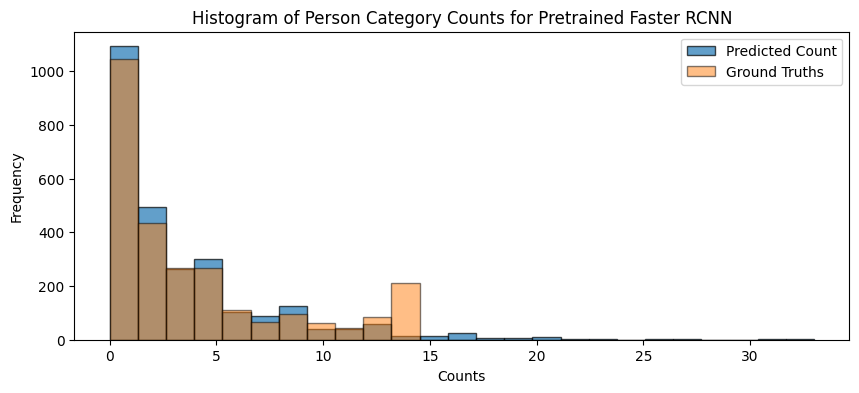

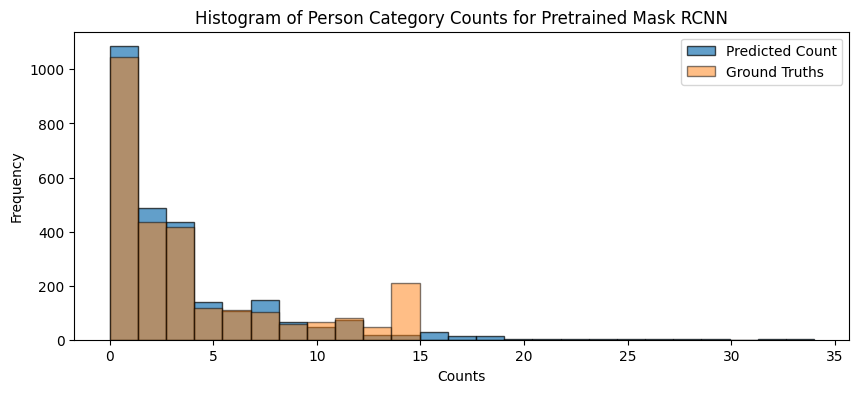

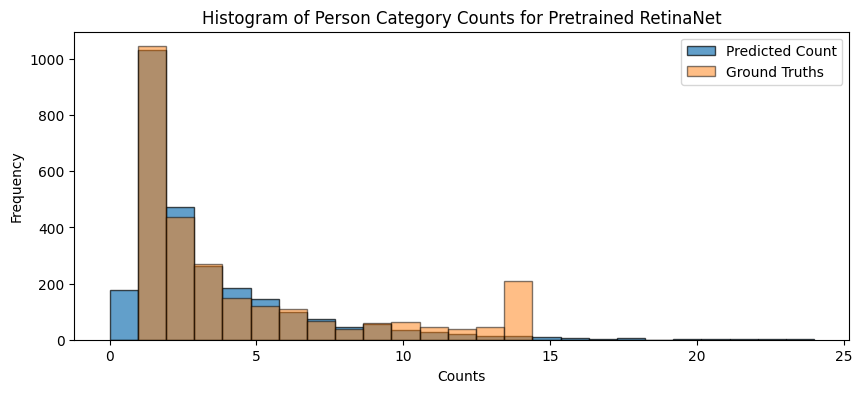

In [ ]:
pretrained_file = ["pretrained_fasterrcnn", "pretrained_maskrcnn", "pretrained_retinanet"] 
display_name = ["Pretrained Faster RCNN", "Pretrained Mask RCNN", "Pretrained RetinaNet"] 
for i in range(len(pretrained_file)): 
    plotHistogram(pretrained_file[i], display_name[i])


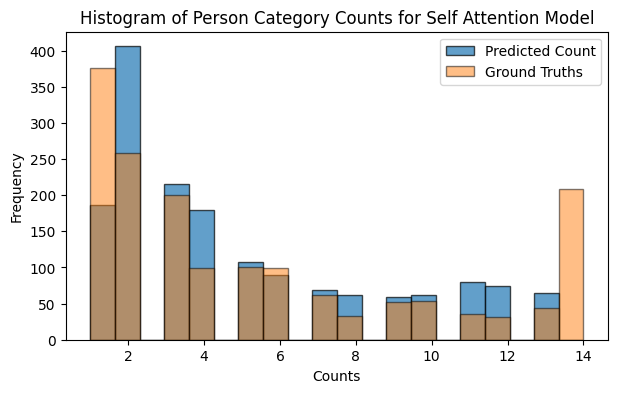

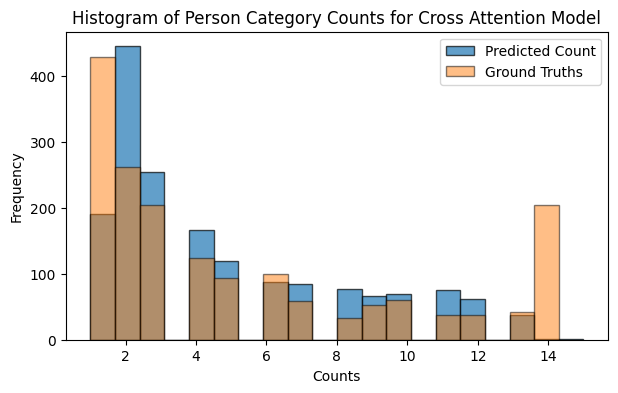

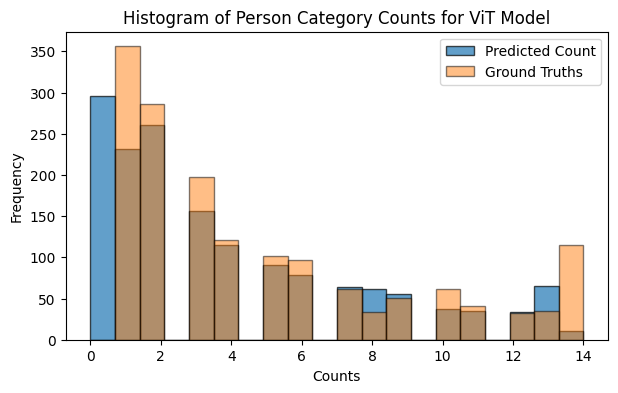

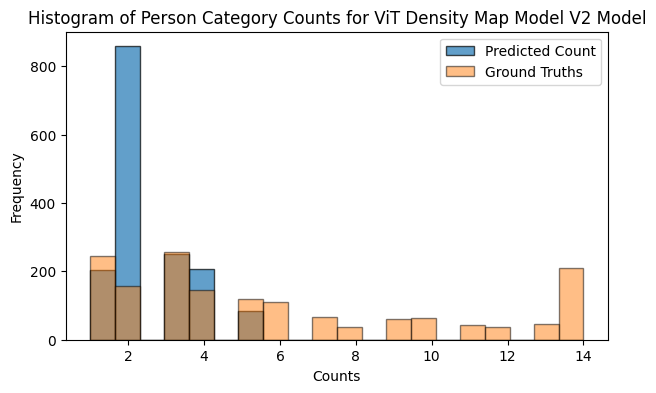

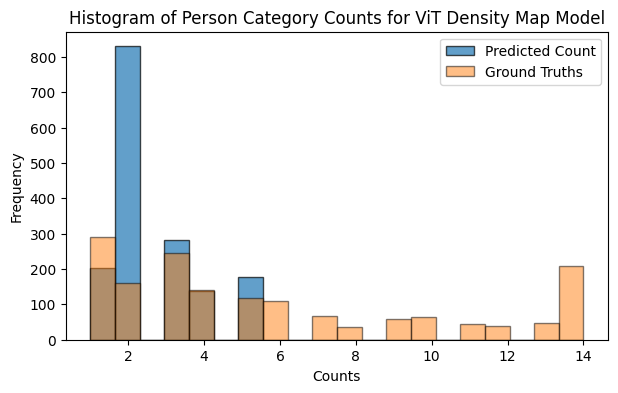

In [169]:
pretrained_file = ["self_attention_v2_4", "cross_attention_v2_5", "ViT_9", "ViT_density_v2_4", "ViT_density_5"] 
display_name = ["Self Attention Model","Cross Attention Model","ViT Model", "ViT Density Map Model V2 Model", "ViT Density Map Model"] 
for i in range(len(pretrained_file)): 
    plotHistogram(pretrained_file[i], display_name[i])


# Displaying Scatter plot

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plotScatter(modelname, display_name):
    extract_element = lambda x: extract_element(x[0]) if isinstance(x, list) and len(x) == 1 else x

    results = pd.read_json(f'{modelname}_results.json')
    results["ground_truths"] = results["ground_truths"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(extract_element)
    results["prediction"] = results["prediction"].apply(lambda x: max(0, round(x)))
    results = results[results["ground_truths"] != 0]
    results = results[results["ground_truths"] != results["prediction"]]

    # Count occurrences of (ground truth, prediction) pairs
    frequency = results.groupby(["ground_truths", "prediction"]).size().reset_index(name="count")

    min_count = min(results["ground_truths"].min(), results["prediction"].min())
    max_count = max(results["ground_truths"].max(), results["prediction"].max())

    plt.figure(figsize=(6, 6))
    plt.scatter(
        frequency["ground_truths"], frequency["prediction"],
        s=frequency["count"] * 10,  # Scale dot size by frequency
        alpha=0.6, edgecolors="black"
    )
    
    # Diagonal line (correct predictions)
    plt.plot([min_count, max_count], [min_count, max_count], 'r--', label="Perfect Prediction")

    plt.xlabel("Ground Truth Count")
    plt.ylabel("Predicted Count")
    plt.title(f"Prediction vs. Ground Truth for {display_name}")
    plt.legend()
    plt.grid(True)
    plt.show()


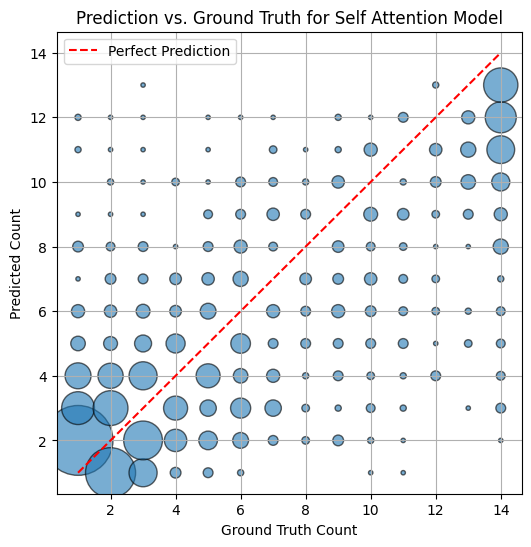

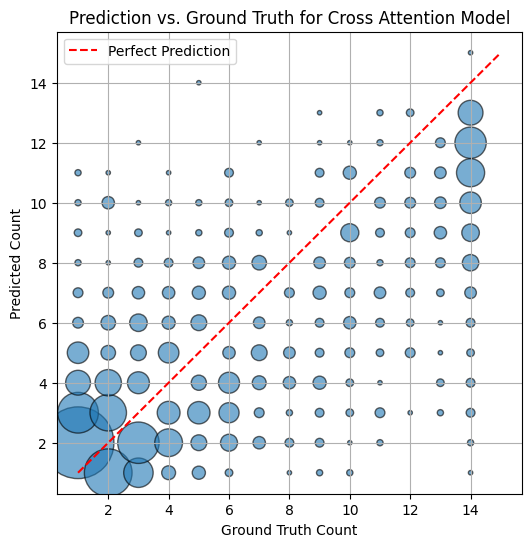

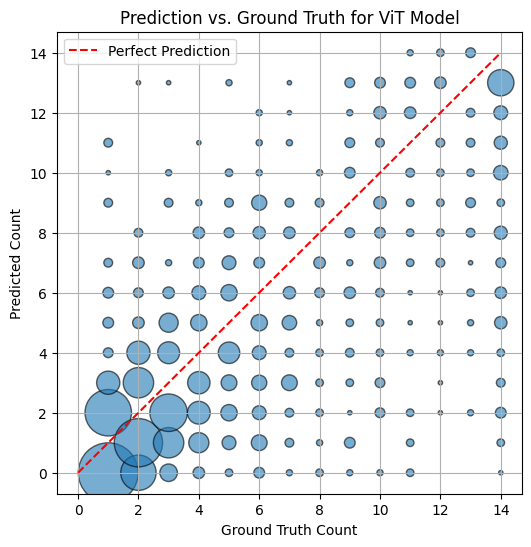

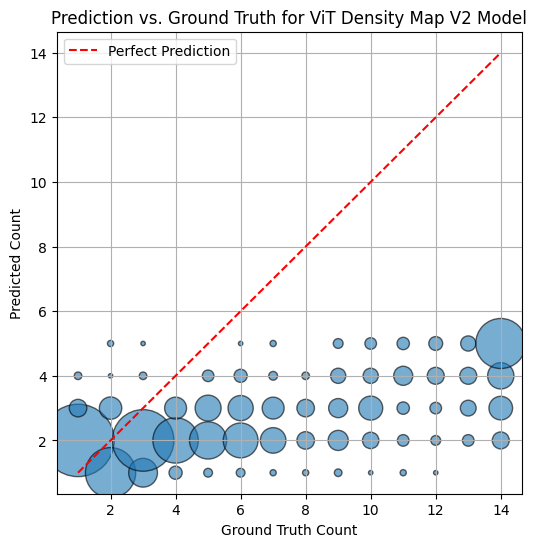

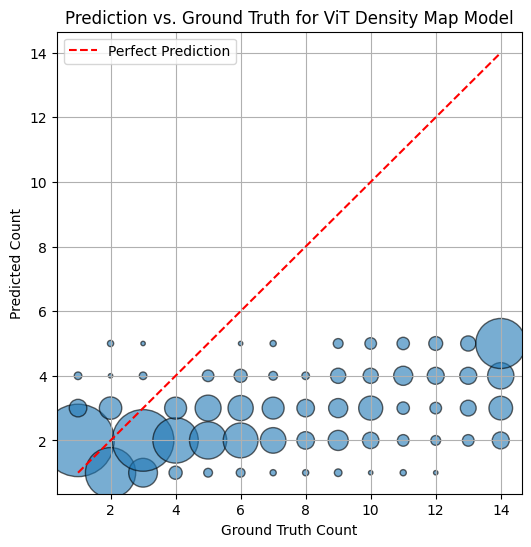

In [156]:
file_name = ["self_attention_v2_4", "cross_attention_v2_5", "ViT_9", "ViT_density_5", "ViT_density_5"] 
display_name = ["Self Attention Model","Cross Attention Model","ViT Model", "ViT Density Map V2 Model", "ViT Density Map Model"] 
for i in range(len(file_name)): 
    plotScatter(file_name[i], display_name[i])
